In [180]:
#importing neccessary packages
import pandas as pd
import numpy as np
import seaborn as sns
import mlflow
import itertools
import pickle
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors 
import matplotlib.pyplot as figure
from matplotlib import cm
from sklearn import metrics
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor


In [181]:
# To import scripts from script folder
import os 
import sys
import warnings
warnings.filterwarnings('ignore')
sys.path.append(os.path.abspath(os.path.join('../scripts')))

In [182]:
# Load dataset

df  = pd.read_csv('../data/clean_data.csv')

In [183]:
df.head()

,Unnamed: 0,auction_id,experiment,date,hour,device_make,platform_os,browser,aware
0,2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0
1,16,008aafdf-deef-4482-8fec-d98e3da054da,exposed,2020-07-04,16,Generic Smartphone,6,Chrome Mobile,1
2,20,00a1384a-5118-4d1b-925b-6cdada50318d,exposed,2020-07-06,8,Generic Smartphone,6,Chrome Mobile,0
3,23,00b6fadb-10bd-49e3-a778-290da82f7a8d,control,2020-07-08,4,Samsung SM-A202F,6,Facebook,1
4,27,00ebf4a8-060f-4b99-93ac-c62724399483,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0


In [184]:
# info of features
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1243 entries, 0 to 1242
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   1243 non-null   int64 
 1   auction_id   1243 non-null   object
 2   experiment   1243 non-null   object
 3   date         1243 non-null   object
 4   hour         1243 non-null   int64 
 5   device_make  1243 non-null   object
 6   platform_os  1243 non-null   int64 
 7   browser      1243 non-null   object
 8   aware        1243 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 87.5+ KB


In [185]:
# columns in dataset
df.columns

Index(['Unnamed: 0', 'auction_id', 'experiment', 'date', 'hour', 'device_make',
       'platform_os', 'browser', 'aware'],
      dtype='object')

In [186]:
# to identify missing values
df.isnull().sum()

Unnamed: 0     0
auction_id     0
experiment     0
date           0
hour           0
device_make    0
platform_os    0
browser        0
aware          0
dtype: int64

In [187]:
#to identify numeric columns
numerical_features=list(df._get_numeric_data().columns)
numerical_features

['Unnamed: 0', 'hour', 'platform_os', 'aware']

In [188]:
#to identify categoricala features
df.select_dtypes(include=['object']).columns

Index(['auction_id', 'experiment', 'date', 'device_make', 'browser'], dtype='object')

In [189]:
#removing unwanted features
del df['auction_id']
df

,Unnamed: 0,experiment,date,hour,device_make,platform_os,browser,aware
0,2,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0
1,16,exposed,2020-07-04,16,Generic Smartphone,6,Chrome Mobile,1
2,20,exposed,2020-07-06,8,Generic Smartphone,6,Chrome Mobile,0
3,23,control,2020-07-08,4,Samsung SM-A202F,6,Facebook,1
4,27,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0
...,...,...,...,...,...,...,...,...
1238,8059,exposed,2020-07-05,21,Generic Smartphone,6,Chrome Mobile,1
1239,8063,exposed,2020-07-04,1,Generic Smartphone,6,Chrome Mobile,1
1240,8064,control,2020-07-09,7,Generic Smartphone,6,Chrome Mobile,0
1241,8069,control,2020-07-10,16,Generic Smartphone,6,Chrome Mobile,0


In [190]:
# converting categorical varaibles to numeric values 
from sklearn.preprocessing import LabelEncoder
lb_encoder=LabelEncoder()
categorical_column=df.columns.tolist()
for column in categorical_column:
    if df[column].dtype=='object':
        df[column]=lb_encoder.fit_transform(df[column])

In [191]:
df.dtypes

Unnamed: 0     int64
experiment     int32
date           int32
hour           int64
device_make    int32
platform_os    int64
browser        int32
aware          int64
dtype: object

In [192]:
df.head()

,Unnamed: 0,experiment,date,hour,device_make,platform_os,browser,aware
0,2,1,2,2,4,6,2,0
1,16,1,1,16,13,6,1,1
2,20,1,3,8,13,6,1,0
3,23,0,5,4,43,6,4,1
4,27,0,0,15,13,6,1,0


In [193]:
# Normalizing dataset 
#Assuming same lines from your example
cols_to_norm = ['Unnamed: 0','experiment','date','hour','device_make','platform_os','browser']
df[cols_to_norm] = df[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

In [194]:
df

,Unnamed: 0,experiment,date,hour,device_make,platform_os,browser,aware
0,0.000000,1.0,0.285714,0.086957,0.035088,1.0,0.285714,0
1,0.001735,1.0,0.142857,0.695652,0.114035,1.0,0.142857,1
2,0.002231,1.0,0.428571,0.347826,0.114035,1.0,0.142857,0
3,0.002603,0.0,0.714286,0.173913,0.377193,1.0,0.571429,1
4,0.003098,0.0,0.000000,0.652174,0.114035,1.0,0.142857,0
...,...,...,...,...,...,...,...,...
1238,0.998513,1.0,0.285714,0.913043,0.114035,1.0,0.142857,1
1239,0.999009,1.0,0.142857,0.043478,0.114035,1.0,0.142857,1
1240,0.999132,0.0,0.857143,0.304348,0.114035,1.0,0.142857,0
1241,0.999752,0.0,1.000000,0.695652,0.114035,1.0,0.142857,0


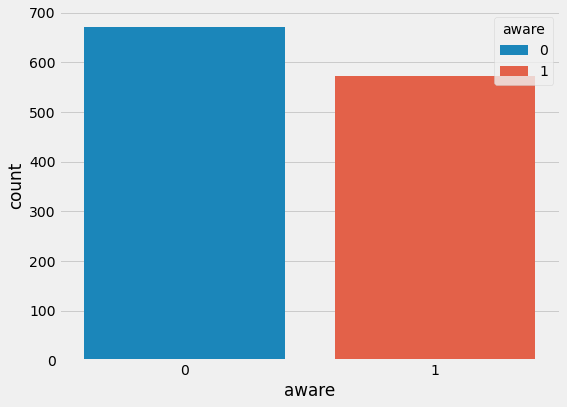

In [195]:
# number of aware and not aware
fig = plt.figure(figsize=(8,6))
ax = sns.countplot(x='aware', data=df,hue="aware",dodge=False)
plt.style.use('fivethirtyeight')
plt.show()

### Model Traning

In [196]:
feature_cols = ["experiment", "hour", "date", 'device_make', 'browser']
#spliting dataset as target and features
X = clean_df[feature_cols]
y = clean_df[['aware']]

test_size = 0.1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

In [197]:
#Random Forest
rfc=RandomForestClassifier(n_estimators=100)
# fitting model with train data
rfc.fit(X_train,y_train)
# to predict results from X_test dataset
pred_rfc=rfc.predict(X_test)
# See First 10 Predictions and They Actual Values
print("Predicted:", pred_rfc[0:10])
print("Actual:", y_test[0:10])

Predicted: [1 1 0 0 1 0 1 0 0 1]
Actual:       aware
900       1
1003      0
671       0
620       0
926       1
997       0
745       1
938       1
451       0
439       1


In [198]:
# Decision Tree
dt=DecisionTreeClassifier()
# fitting model with train data
dt.fit(X_train,y_train)
# to predict results from X_test dataset
pred_dt=dt.predict(X_test)
# See First 10 Predictions and They Actual Values
print("Predicted:", pred_dt[0:10])
print("Actual:", y_test[0:10])


Predicted: [1 0 0 0 1 0 1 1 1 0]
Actual:       aware
900       1
1003      0
671       0
620       0
926       1
997       0
745       1
938       1
451       0
439       1


In [199]:
# Logistic regression
lr=LogisticRegression()
# fitting model with train data
lr.fit(X_train,y_train)
# to predict results from X_test dataset
pred_lr=lr.predict(X_test)
# See First 10 Predictions and They Actual Values
print("Predicted:", pred_lr[0:10])
print("Actual:", y_test[0:10])

Predicted: [0 1 0 0 1 0 1 0 0 0]
Actual:       aware
900       1
1003      0
671       0
620       0
926       1
997       0
745       1
938       1
451       0
439       1


In [200]:
# Bernouilli NB
bnb = BernoulliNB()
# We fit our model with our train data
bnb.fit(X_train, y_train)
# Then predict results from X_test data
pred_bnb = bnb.predict(X_test)

# See First 10 Predictions and They Actual Values
print("Predicted:", pred_bnb[0:10])
print("Actual:", y_test[0:10])

Predicted: [0 0 0 0 0 0 0 0 0 0]
Actual:       aware
900       1
1003      0
671       0
620       0
926       1
997       0
745       1
938       1
451       0
439       1


In [201]:
# Define XGBoost Model
xgb = XGBClassifier(n_estimators=1000, learning_rate=0.05)
# We fit our model with our train data
xgb.fit(
    X_train, y_train,
    # That means if model don't improve it self in 5 rounds, it will stop learning
    # So you can save your time and don't overtrain your model.
    early_stopping_rounds=5,
    # We provide Test data's to evaluate model performance
    eval_set=[(X_test, y_test)],
    verbose=False
 )
# Then predict results from X_test data
pred_xgb = xgb.predict(X_test)

# See First 10 Predictions and They Actual Values
# print("Predicted:", pred_xgb[0:10])
print("Actual:", y_test[0:10])

Actual:       aware
900       1
1003      0
671       0
620       0
926       1
997       0
745       1
938       1
451       0
439       1


### Confusion Matrixes
    # First parameter is actual value
    # second parameter is value that we prediceted

In [209]:

# Random Forest 
cm_rfc = confusion_matrix(y_test, pred_rfc)
# Desicion Tree
cm_dt = confusion_matrix(y_test, pred_dt)
# Logistic Regression
#BNB
cm_bnb=confusion_matrix(y_test, pred_bnb)
#Logistic Regression
cm_lr = confusion_matrix(y_test, pred_lr)
# XGBoost 
cm_xgb = confusion_matrix(y_test, pred_xgb)

print("***********************")
print("Confusion Matrixes")
print("***********************")
print("Random Forest:\n", cm_rfc)
print("Desicion Tree:\n", cm_dt)
print("Logistic Regression:\n", cm_lr)
print("Bernouilli Naive Bias:\n", cm_bnb)
print("XGBoost:\n", cm_xgb)

***********************
Confusion Matrixes
***********************
Random Forest:
 [[44 21]
 [34 26]]
Desicion Tree:
 [[39 26]
 [33 27]]
Logistic Regression:
 [[58  7]
 [47 13]]
Bernouilli Naive Bias:
 [[65  0]
 [60  0]]
XGBoost:
 [[51 14]
 [41 19]]


In [213]:
# Accuracy Scores
# First parameter is actual value
# second parameter is value that we prediceted

# Random Forest 
acc_rfc = accuracy_score(y_test, pred_rfc)
# Desicion Tree
acc_dt = accuracy_score(y_test, pred_dt)
# Logistic Regression
acc_lr = accuracy_score(y_test, pred_lr)
# Bernouilli Naive Bias
acc_bnb = accuracy_score(y_test, pred_bnb)
# XGBoost 
acc_xgb = accuracy_score(y_test, pred_xgb)

print("***********************")
print("Accuracy Scores")
print("***********************")
print("Random Forest:", acc_rfc)
print("Desicion Tree:", acc_dt)
print("Logistic Regression:", acc_lr)
print("Bernouilli Naive Bias:", acc_bnb)
print("XGBoost:", acc_xgb)

***********************
Accuracy Scores
***********************
Random Forest: 0.56
Desicion Tree: 0.528
Logistic Regression: 0.568
Bernouilli Naive Bias: 0.52
XGBoost: 0.56


### Sklearn Pipeline

In [215]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:

        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
         plt.text(j, i, cm[i, j],horizontalalignment="center",color="white" if cm[i, j] > thresh else "black")
         plt.tight_layout()
         plt.ylabel('True label')
         plt.xlabel('Predicted label')

In [220]:
pipelin=Pipeline([('scalar1',StandardScaler()),
                     ('pca1',PCA(n_components=2)),
                     ('lr_classifier',LogisticRegression(random_state=0))])

In [221]:
pipedes=Pipeline([('scalar2',StandardScaler()),
                     ('pca2',PCA(n_components=2)),
                     ('lr_classifier',DecisionTreeClassifier())])

In [222]:

pipeber=Pipeline([('scalar3',StandardScaler()),
                     ('pca3',PCA(n_components=2)),
                     ('rf_classifier',BernoulliNB())])



In [223]:
piperan=Pipeline([('scalar3',StandardScaler()),
                     ('pca3',PCA(n_components=2)),
                     ('rf_classifier',RandomForestClassifier())])

In [224]:
pipexgb=Pipeline([('scalar3',StandardScaler()),
                     ('pca3',PCA(n_components=2)),
                     ('rf_classifier',XGBClassifier())])

In [227]:
# to list defined piplines 
piplines=pipelines = [pipelin, pipedes, piperan,pipeber,pipexgb]

In [228]:
# Dictionary of pipelines and classifier types for ease of reference
pipe_dict = {
        0: 'Logistic Regression', 
        1: 'Decision Tree', 
        2: 'RandomForest',
        3:'Bernouilli Naive Bias',
        4:'XGBoost'
      }

# Fit the pipelines
for pipe in pipelines:
  pipe.fit(X_train, y_train)

In [229]:
for i,model in enumerate(pipelines):
    print("{} Test Accuracy: {}".format(pipe_dict[i],model.score(X_test,y_test)))

Logistic Regression Test Accuracy: 0.52
Decision Tree Test Accuracy: 0.552
RandomForest Test Accuracy: 0.552
Bernouilli Naive Bias Test Accuracy: 0.52
XGBoost Test Accuracy: 0.544


In [231]:
#Print model with best accuracy
best_accuracy=0.0
best_classifier=0
best_pipeline=""
for i,model in enumerate(pipelines):
    if model.score(X_test,y_test)>best_accuracy:
        best_accuracy=model.score(X_test,y_test)
        best_pipeline=model
        best_classifier=i
    
print('Classifier with best accuracy:{}'.format(pipe_dict[best_classifier]))

Classifier with best accuracy:Decision Tree


In [232]:
# To print model with accurcy 
model=RandomForestClassifier()
model.fit(X_train, y_train)
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.536


accuracy: 56.8%
Confusion matrix, without normalization


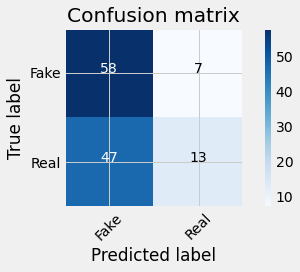

In [233]:
# confusion matrix for LogisticRegression
pipe = Pipeline([('model', LogisticRegression(random_state=0))])
model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

accuracy: 56.0%
Confusion matrix, without normalization


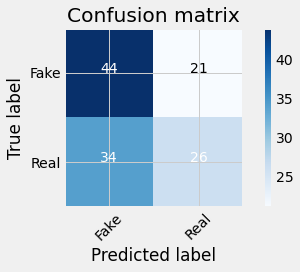

In [234]:
# confusion matrix for RF
pipe = Pipeline([('model', RandomForestClassifier(random_state=0))])
model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

accuracy: 59.2%
Confusion matrix, without normalization


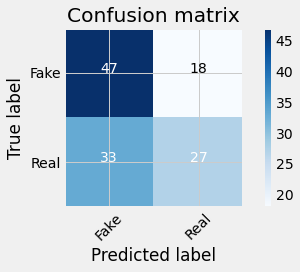

In [235]:
# confusion matrix for RF
pipe = Pipeline([('model', XGBClassifier())])
model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

In [236]:
plt.barh(feature,rfc_feature_importance_c,color='purple')

NameError: name 'feature' is not defined